# Exercise 3 - Spelling Correction with Naive Bayes

In this exercise you will learn about a fun application of the *Naive Bayes* classifier: Spelling correction. For the
informal and vivid character of natural language, the correction of syntactic and semantic errors in written lan-
guage is an extremely hard task. Here you will challenge this problem by applying one of the simplest classification
algorithms, namely Naive Bayes and see how it performs.

### Submission

- Deadline of submission:
        x.y.z
- Mail your solution notebook or a link to your gitlab repository (with the solution notebook inside) to:
        paul.kahlmeyer@uni-jena.de

In the event of a persistent problem, do not hesitate to contact the course instructors.

In [1]:
import numpy as np
import re
import collections
import os
import string
import csv
import matplotlib.pyplot as plt
import pickle

## Problem statement
We frame spelling correction as a classification problem and use Bayesian inference to obtain results. Although the
basic problem statement is straightforward, there is plenty of room to improve the here applied models, initially
published by Peter Norvig.

Given an observation $x$ and a corpus of words $W$. For spelling correction, we want to find the most likely correction $w\in W$ for $x$.
In other words, we are looking for 

\begin{align}
\text{argmax}_{w\in W}p(w|x)&=\text{argmax}_{w\in W}\cfrac{p(x|w)p(w)}{p(x)}\\
&=\text{argmax}_{w\in W}p(x|w)p(w)
\end{align}

In practice, we do not want to maximize over the complete corpus of words, but rather only over a set of candidate words $C_x\subset W$ that depends on the observed pattern $x$.

\begin{align}
\text{argmax}_{w\in C}p(x|w)p(w)
\end{align}

## Language Model
The probability $p(w)$ is also called **language model**, since it represents our model of how words are distributed.
There are multiple classes of language models. 
The simplest class of model is the unigram model, where the probability of each word is fixed and can be obtained by using the frequency of its occurrence in a given corpus.
Within the directory `books` you will find several `.txt` files that contain (parts) of books from the [Project Gutenberg](www.gutenberg.org). This source shall provide the basis for obtaining the corpus and for training a language
model.

Note: Due to some legal issues, Project Gutenberg blocks IP adresses coming from germany.

### Task 1
Load the book texts from the `.txt` files, filter the alphabetic
expressions (hint: use regex) and calculate the frequencies of occurrences of the existing words.
What are the top 10 most occuring words?

Hints:
- the files are encoded in utf-8
- use [regex](https://docs.python.org/3/library/re.html) to filter for words

In [2]:
# TODO: load books and count words

p = 'books'
words = []
for f in os.listdir(p):
    content =  open(os.path.join(p,f), encoding='utf8').read()
    words += re.findall(r'\w+', content)


n_words = len(words)
words = collections.Counter(words)
words.most_common(10)

[('the', 15169),
 ('and', 10048),
 ('to', 9813),
 ('of', 8735),
 ('I', 7246),
 ('a', 7090),
 ('in', 5225),
 ('was', 4714),
 ('that', 4443),
 ('his', 3733)]

### Task 2
Use the loaded corpus to implement a function that resembles our language model.
Use relative frequencies as estimates for $p(w)$.

In [3]:
def language_model(w):
    # TODO: implement language model
    return words[w] / n_words

## Candidate Words
Real-world-spelling-errors take multiple shapes. There are typographical errors like insertions, deletions and trans-
positions of letters, and there are cognitive errors where the writer substitutes a wrong spelling of a homophone or
near-homophone (e.g., dessert for desert, or piece for peace). The detection of the latter require context information
and therefore are hard to detect. Thus we focus on the former, which are errors that were produced by the following
operations:
- transposition (e.g. "caress" for "actress" : "ac" $\rightarrow$ "ca")
- deletion ("acress" for "actress": missing "t")
- substitutions ("acress" for "access": substituted "r" for "c")
- insertions ("actresss" for "actress": added "s")

Given an observation $x$, we create a set of possible candidates $C_x$ by applying all the possible edit operators on $x$. By concatenating operations, you can transform each word into any other arbitrary word. Yet, to keep things simply
we only consider candidates with *at most one* edit distance away from $x$. 

For instance, the correction candidates for the word "nie", could be:

\begin{equation}
C_{\text{nie}} = \{\text{die}, \text{lie}, \text{pie}, \text{tie}, \text{nice}, \text{nine}, \text{in}\}
\end{equation}

### Task 3
Implement a function that creates a set of all possible correction candidates for a given observation $x$,
that are at most one edit distance away from $x$. You do not need to concatenate operations! To make things even simpler:
- you can ignore candidates, that do not occur in our corpus
- if none of the candidates is known, return the word itself

What is the set of correction candidates for the word "frod"?

In [4]:
# the following functions were written by Peter Norvig ;) (https://norvig.com/spell-correct.html)

def edits1(word):
    letters    = string.ascii_lowercase
    splits     = [(word[:i], word[i:], i)    for i in range(len(word) + 1)]
    deletes    = [(L + R[1:], i)               for L, R, i in splits if R]
    transposes = [(L + R[1] + R[0] + R[2:], i) for L, R, i in splits if len(R)>1]
    replaces   = [(L + c + R[1:], i)           for L, R, i in splits if R for c in letters]
    inserts    = [(L + c + R, i)               for L, R, i in splits for c in letters]
    return deletes,transposes,replaces,inserts

def known(word_set): 
    return [(w,i) for w,i in word_set if w in words]

def candidates(word): 
    # TODO: Estimate candidates (you might need additional functions)
    deletes, transposes, replaces, inserts = edits1(word)
    ret = []
    ret += [(('del',i), w) for w,i in known(deletes)]
    ret += [(('trans',i), w) for w,i in known(transposes)]
    ret += [(('sub',i), w) for w,i in known(replaces)]
    ret += [(('ins',i), w) for w,i in known(inserts)]
    if word in words or len(ret)==0:
        ret.append((('#',0), word))
    return ret

In [5]:
candidates("frod")

[(('del', 0), 'rod'),
 (('del', 3), 'fro'),
 (('sub', 1), 'food'),
 (('sub', 3), 'from')]

## Error Model
Recall the problem statement:
The probability $p(x|w)$ for $w\in C\subset W$ is also called **error model**, since it represents our model of correct words (candidates) are altered into the observed pattern $x$.

A very simple error model is can be achieved by setting

\begin{equation}
p(x|w) := p(w)
\end{equation}

which reduces our initial problem to 

\begin{align}
\text{argmax}_{w\in C}p(w)p(w) = \text{argmax}_{w\in C}p(w)
\end{align}

### Task 4
Implement a function `correction`, that returns $\text{argmax}_{w\in W}p(w|x)$ for a given input $x$, based on the above definition.

Also think about what `correction` should return
- if $x$ is a known word?
- if $x$ is unknown and has no correction candidates?

In [6]:
def correction(x): 
    # TODO: return correction candidate
    can = candidates(x)
    can = [c[1] for c in can]
    probs = [language_model(c[1]) for c in can]
    return can[np.argmax(probs)]

In [7]:
correction('frod')

'rod'

### Task 5
The file `validate.csv` contains a list of evaluation data, where each row contains a sample of the form:

\begin{equation}
\text{right, misspelled}
\end{equation}

Use the validation data set to test your first version of the spelling correction function. Use only the data, where the correct word is actually in our word corpus $W$.

What is your success rate?


In [8]:
# TODO: estimate sucess rate on validation data

def validate(correction, verbose=False):
    # load validation data
    with open("validate.csv", "r") as file:
        r = csv.reader(file)
        tmpset = [row for row in r if row]
    testset = [x for x in tmpset if x[0] in words]
        
    # check if correction is actually the correct word
    failed = []
    if verbose:
        print("  i{:>20}{:>20}{:>20}".format("expected", "actual", "original"))
    for i, (right, wrong) in enumerate(testset):
        c = correction(wrong)
        if c != right: 
            failed.append((right, c, wrong))
            if verbose:
                print("{:3d}{:>20}{:>20}{:>20}".format(i, right, c, wrong))
    success_rate = 1 - len(failed) / len(testset)
    return failed, success_rate

In [9]:
failed0, sr0 = validate(correction)
print(sr0)

0.7756410256410257


## The Noisy Channel Model

By analyzing the output of your spelling corrector, you find examples where the corrected word is indeed a real
word, but not the expected one, for example:

\begin{equation}
w=\text{"level"}, x=\text{"leval"}, \text{correction}=\text{"legal"}
\end{equation}

This phenomena occurs due to the simplistic nature of our language model. 
Unigram models do not include context sensitive information. Thus, improving the language model should naturally
improve the validation results.


Chapter 5.1 of the book *Speech and Language Processing* by Daniel Jurafsky & James H. Martin introduces another model to improve the success rate. 
Instead of treating each error equally, we now consider the probability of error occurrences.
You find this chapter in the file `chapter5.pdf`.

### Task 6

Read the chapter. In order to apply the noisy channel model, we need four confusion matrices:
- deletion
- insertion
- substitution
- transposition

As suggested, we want to build them from a list of misspellings. You can find a [pickeled](https://docs.python.org/3/library/pickle.html) dictionary of misspellings in `misspellings.p` (key = word, value = list of misspellings).

Load this dictionary, and compute the four confusion matrices.

In [10]:
# TODO: load misspellings.p and compute confusion matrices

# load misspellings
misspellings = pickle.load(open('misspellings.p', 'rb') )

# compute confusion matrices
letters = '#'+string.ascii_lowercase

# deletion matrix
deletion = np.zeros((len(letters), len(letters)-1))
for i,x in enumerate(letters):
    for j,y in enumerate(letters[1:]):
        xy = x+y
        yx = y+x
        for s in misspellings:
            if x=='#':
            # find instances where first letter was removed
                for ms in misspellings[s]:
                    if s[1:] == ms:
                        deletion[i,j] += 1
            
            elif xy in s:
            # find instances where xy was typed as x
                for ms in misspellings[s]:
                    if xy not in ms and x in ms:
                        deletion[i,j] += 1
deletion = deletion/np.sum(deletion)

# insertion matrix
insertion = np.zeros((len(letters), len(letters)-1))
for i,x in enumerate(letters):
    for j,y in enumerate(letters[1:]):
        xy = x+y
        for s in misspellings:
            if x=='#':
                # find instances first letter was inserted
                for ms in misspellings[s]:
                    if ms[1:] == s:
                        insertion[i,j] += 1
            elif x in s and xy not in s:
                
                # find instances where x was typed as xy
                for ms in misspellings[s]:
                    if xy in ms:
                        insertion[i,j] +=1
insertion = insertion/np.sum(insertion)

# substitution matrix
substitution = np.zeros((len(letters)-1, len(letters)-1))
for i,x in enumerate(letters[1:]):
    for j,y in enumerate(letters[1:]):
        # find instances where x was typed as y
        for s in misspellings:
            if x in s and y not in s:
                for ms in misspellings[s]:
                    if y in ms and x not in ms:
                        substitution[i,j] +=1
substitution = substitution/np.sum(substitution)

# transposition matrix
transposition = np.zeros((len(letters)-1, len(letters)-1))
for i,x in enumerate(letters[1:]):
    for j,y in enumerate(letters[1:]):
        # find instances where xy was typed as yx
        xy = x+y
        yx = y+x
        for s in misspellings:
            if xy in s and yx not in s:
                for ms in misspellings[s]:
                    if yx in ms and not xy in ms:
                        transposition[i,j] +=1
transposition = transposition/np.sum(transposition)

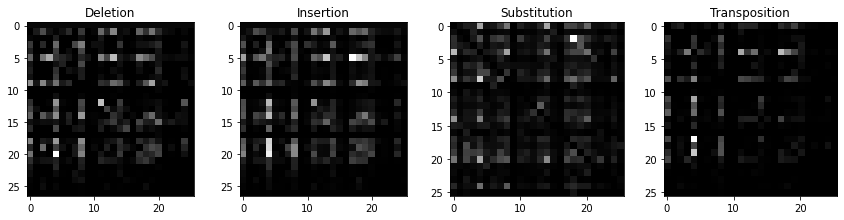

In [11]:
fs = 3
fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize=(4*fs,fs))

axs[0].imshow(deletion, cmap='gray')
axs[0].set_title('Deletion')

axs[1].imshow(insertion, cmap='gray')
axs[1].set_title('Insertion')

axs[2].imshow(substitution, cmap='gray')
axs[2].set_title('Substitution')

axs[3].imshow(transposition, cmap='gray')
axs[3].set_title('Transposition')

plt.tight_layout()

### Task 7
Now that we have the confusion matrices, we can use them to alter the calculation of the error model $p(x|w)$.

Implement the noisy channel `error_model` function.

Based on this error model implement the `correction_noisy_channel` function that outputs the best correction candidate.

Similar to task 5, calculate the sucess rate of the new correction function.

In [12]:
def letter_idx(letter):
    return [i for i,l in enumerate(string.ascii_lowercase) if l==letter][0]

def error_model(x,can):
    # TODO: Calculate p(x|can) based on confusion matrices
    (transf, idx), c = can
    if transf == 'del':
        if idx == 0: 
            return deletion[0, letter_idx(x[idx+1])]
        else:
            return deletion[letter_idx(x[idx])+1, letter_idx(x[idx-1])]
    elif transf == 'ins':
        idx = min(idx, len(x)-1)
        if idx == 0:
            return insertion[0, letter_idx(c[idx])]
        else:
            return insertion[letter_idx(x[idx])+1, letter_idx(c[idx])]
    elif transf == 'sub':
        return substitution[letter_idx(x[idx]), letter_idx(c[idx])]
    elif transf == 'trans':
        return substitution[letter_idx(x[idx]), letter_idx(x[idx+1])]
    else:
        return 1

def correction_noisy_channel(x): 
    # TODO: return best correction candidate based on noisy channel model
    can = candidates(x)
    p_w = np.array([language_model(c[1]) for c in can])
    p_x_w = np.array([error_model(x,c) for c in can])
    
    return can[np.argmax(p_w*p_x_w)][1]

In [13]:
failed0, sr0 = validate(correction)
failed1, sr1 = validate(correction_noisy_channel)
print(sr0, sr1)

0.7756410256410257 0.8365384615384616
